コードに関してこちらの記事を参考にしています。
https://medium.com/@jeremy-k/unlocking-openai-clip-part-3-optimizing-image-embedding-storage-and-retrieval-pickle-vs-faiss-25d0f02c049d

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-relpdyku
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-relpdyku
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=2497ea5b5c6ee716aa131b8ec9887b657f0228c790eea3ba82327fadc16937dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-emkeyr11/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.4 MB/s eta 0:00:00


In [11]:
from PIL import Image
import torch
import clip
import numpy as np
import faiss
import os
import pandas as pd

In [6]:
#read all image names
images = []
for root, dirs, files in os.walk('/content/drive/MyDrive/人工知能演習/image'):
    for file in files:
        if file.endswith('png'):
            images.append(root  + '/'+ file)

In [9]:
#Load CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

#Define the emb variable to store embeddings
emb = {}

#Extract embeddings and store them in the emb variable
for img in images:
    with torch.no_grad():
        image = preprocess(Image.open(img)).unsqueeze(0).to(device)
        image_features = model.encode_image(image)
        emb[img] = image_features

#Create Faiss index using FlatL2 type. 512 is the number of dimensions of each vectors

index = faiss.IndexFlatL2(512)
#Convert embeddings and add them to the index

for key in emb:
    #Convert to numpy
    vector = emb[key].detach().cpu().numpy()
    #Convert to float32 numpy
    vector = np.float32(vector)
    #Normalize vector: important to avoid wrong results when searching
    faiss.normalize_L2(vector)
    #Add to index
    index.add(vector)

#Store the index locally
faiss.write_index(index,"vector.index")

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 44.2MiB/s]


In [10]:
index  = faiss.read_index("vector.index")

In [16]:
n = index.ntotal  # データベースに保存されているベクトルの数
dimension = index.d  # ベクトルの次元
vectors = index.reconstruct_n(0, n)  # すべてのベクトルを抽出

# 2. ベクトルをpandasのDataFrameに変換
df = pd.DataFrame(vectors)

# 3. DataFrameをCSV形式で保存
csv_path = "faiss_vectors.csv"
df.to_csv(csv_path, index=False)

In [17]:
from sklearn.manifold import TSNE
from ast import literal_eval

datafile_path = "faiss_vectors.csv"
df = pd.read_csv(datafile_path)


In [20]:
matrix = np.array(df.values.tolist())
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(16, 2)

In [21]:
# x成分とy成分を抜き出す
# ベクトルを2つのリストに分解: x_coords と y_coords
x_components, y_components = zip(*vis_dims)

In [22]:
df["x_components"] = x_components
df["y_components"] = y_components
df["image_name"] = images
df.head()

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,x_components,y_components,image_name
0,-0.051793,0.002995,0.022392,0.012529,0.031392,-0.049930,0.023463,-0.030368,0.054029,-0.020913,...,-0.046646,-0.023416,-0.009804,-0.046017,0.079133,-0.043991,-0.014869,-200.018921,-19.759001,/content/drive/MyDrive/人工知能演習/image/図6-1.png
1,-0.050246,-0.021193,0.002166,0.025032,0.033664,-0.033459,0.018467,-0.007189,0.031665,-0.023760,...,-0.028258,-0.011823,-0.004469,-0.036344,0.100219,-0.032914,0.005585,95.993805,-158.091263,/content/drive/MyDrive/人工知能演習/image/図6-2.png
2,-0.014863,-0.007453,0.013715,0.016440,0.046519,-0.031866,0.016429,0.000232,0.021737,-0.015889,...,-0.031424,-0.020655,-0.021836,-0.038552,0.079841,-0.020876,-0.028754,64.956360,-59.655998,/content/drive/MyDrive/人工知能演習/image/図6-3.png
3,-0.058692,0.003739,0.016463,0.000401,0.032092,-0.087818,0.018265,-0.008262,0.023450,-0.028169,...,-0.003702,-0.031062,0.027017,-0.021746,0.085857,-0.035549,-0.009598,165.867310,-51.850224,/content/drive/MyDrive/人工知能演習/image/表6-1.png
4,-0.041232,-0.009700,-0.003932,-0.010657,0.015041,-0.057658,0.038944,0.002381,0.013812,-0.005545,...,-0.021303,-0.030756,0.005765,-0.036921,0.080056,-0.017088,-0.019051,66.979683,155.807159,/content/drive/MyDrive/人工知能演習/image/表6-2.png


In [23]:
!pip install japanize-matplotlib

import japanize_matplotlib
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 39.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=23692e089c3b5f862bbe2f538dae3cf52ec2e3b74649d0cee8d6ad4c55348b41
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


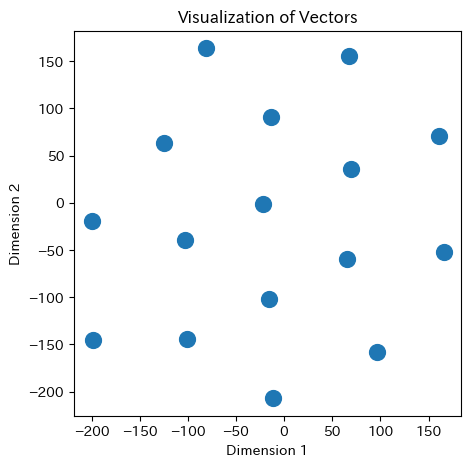

In [27]:
import matplotlib
import numpy as np

# プロット
plt.figure(figsize=(5, 5))
plt.scatter(df['x_components'],df['y_components'], s=130)

# グラフのタイトルと軸ラベルを設定
plt.title("Visualization of Vectors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
#Embedding of the input image
input_image = preprocess(Image.open("teddy.jpg")).unsqueeze(0).to(device)
input_image_features = model.encode_image(input_image)

In [30]:
detect_figure_image_path1 = "/content/drive/MyDrive/人工知能演習/detected_figure/slide_1.jpg"
detect_figure_image_path2 = "/content/drive/MyDrive/人工知能演習/detected_figure/slide_2.jpg"
detect_figure_image_path3 = "/content/drive/MyDrive/人工知能演習/detected_figure/slide_22.jpg"

In [36]:
#Embedding of the input image
input_image = preprocess(Image.open(detect_figure_image_path3)).unsqueeze(0).to(device)
input_image_features = model.encode_image(input_image)
input_image_features = input_image_features.detach().cpu().numpy()
input_image_features = np.float32(input_image_features)
faiss.normalize_L2(input_image_features)

#Search the top 5 images
probs, indices = index.search(input_image_features, 3)

print('probs',probs)
for indice in indices[0]:
  print(images[indice])

probs [[0.18118346 0.18905038 0.2173186 ]]
/content/drive/MyDrive/人工知能演習/image/表6-1.png
/content/drive/MyDrive/人工知能演習/image/表6-2.png
/content/drive/MyDrive/人工知能演習/image/図6-2.png


In [39]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('/content/drive/MyDrive/人工知能演習/secret_key.json', scope)
client = gspread.authorize(creds)

In [40]:
def get_value_from_sheet(keyword):
    # スプレッドシートを開く
    sh = client.open_by_url('https://docs.google.com/spreadsheets/d/19l9d0WhZmB3WDB3Ij5WrJCMjSv0mdRY2cGK4HK1r8m0/edit#gid=0')  # スプレッドシートの名前を指定
    worksheet = sh.worksheet("シート1")

    # A1~A24のセルを検索
    result = []

    for i in range(1, 25):
        cell_value = worksheet.cell(i, 1).value
        if keyword in cell_value:
            # 対応するB列の値を返す
            result.append(worksheet.cell(i, 2).value)
    return result

In [43]:
# 使用例
value = get_value_from_sheet("図6-3")  # "Sheet1"はワークシートの名前
print(value)

['そこで,英語に近い記号で機械語のプログラムを表現することが考案された。これをアセンブリ言語(assembly language)による表現という。アセンプリ言語による表現の例を,図6.3に示す。']


In [ ]:
# retrieve結果
# slide_1.jpg
# ['そこで,英語に近い記号で機械語のプログラムを表現することが考案された。これをアセンブリ言語(assembly language)による表現という。アセンプリ言語による表現の例を,図6.3に示す。']

# slide2.jpg
# ['典型的な算術演算命令の一覧を表6.1に,論理演算命令の一覧を表6.2に示す。算術論理演算命令は,レジスタ間の演算か,レジスタと即値との間の演算のどちらかに限る。したがって,命令形式は,R型かI型となる。', '表6.1および表6.2の各項目で,addとかsubとか並んでいるものは,アセンプリ言語の操作コード(場合によってauxフィールドを一部含む場合がある)である。']

# slide_22.png
#['典型的な算術演算命令の一覧を表6.1に,論理演算命令の一覧を表6.2に示す。算術論理演算命令は,レジスタ間の演算か,レジスタと即値との間の演算のどちらかに限る。したがって,命令形式は,R型かI型となる。', '表6.1および表6.2の各項目で,addとかsubとか並んでいるものは,アセンプリ言語の操作コード(場合によってauxフィールドを一部含む場合がある)である。']
